In [ ]:
# module TopOpt99neo

# include("FastConv.jl/src/FastConv.jl")
# import .FastConv.fastconv

using LinearAlgebra, SparseArrays
using Plots: heatmap, savefig
# using PlotUtils:cgrad
using ImageFiltering: imfilter
using Statistics: mean

using ForwardDiff

BLAS.set_num_threads(1)

# abstract type top99neo end
# abstract type top_result end

# abstract type Filter end

include("utils.jl")

In [ ]:
mutable struct SetUp
# mutable struct SetUp <: top99neo
    nelx::Int
    nely::Int
    # volfrac::Float64
    # rmin::Float64

    # ftBC::Symbol
    eta::Float64
    beta::Int
    betaCnt::NTuple{4,Int}

    move::Float64
    maxit::Int
    maxchang::Float64

    pasS::Array{Int}
    pasV::Array{Int}
    # act

    function SetUp()
        nelx = 100
        nely = 50
        # volfrac = 0.3
        maxit = 300
        move = 0.1
        beta = 2
        eta = 0.5
        maxchang = 1e-6
        # penalCnt = {maxit+1, 3, 25, 0.25}
        betaCnt = (1, 50, 10, 2) # continuation scheme on beta parCont = { istart,maxPar,steps,deltaPar }
    
        pasS, pasV = Array([]), Array([])
        # act = setdiff([1:nEl]', union(pasS, pasV))
        
        new(nelx, nely, eta, beta, betaCnt, move, maxit, maxchang, pasS, pasV)
    end

end

In [ ]:
setup = SetUp()
# setup.nelx = 20
# setup.nely = 10
# setup.maxit = 100
# typeof(setup.nodeNrs)

In [ ]:

mutable struct Mat
    E0::Float64
    Emin::Float64
    ν::Float64
    penal::Float64
    volfrac::Float64

    function Mat()
        # E0 = 1
        # Emin = 1e-9
        # nu = 0.3
        E0 = 1
        Emin = 1e-9
        ν = 0.3
        penal = 3.0
        volfrac = 0.3
        new(E0, Emin, ν, penal, volfrac)
    end
end

In [ ]:
mat = Mat()

In [ ]:
mutable struct DiscretizationFeature
    nEl::Int
    nodeNrs::Array{Int,2}
    nDof::Int
    act

    cMat::Array{Int}
    Iar::Array{Int}
    Ke::Array{Float64,1}
    Ke0::Array{Float64,2}
    
    function DiscretizationFeature(setup::SetUp, mat::Mat)
        nelx = setup.nelx
        nely = setup.nely
        pasS, pasV = setup.pasS, setup.pasV
        ν = mat.ν
    
        nEl = nely * nelx
        nodeNrs = reshape(1:(1+nelx)*(1+nely), nely + 1, nelx + 1)
        nDof = (nely + 1) * (nelx + 1) * 2
        act = setdiff(collect(1:nEl), union(pasS, pasV))
    
        cVec = reshape(2 * nodeNrs[1:end-1, 1:end-1] .+ 1, nEl, 1)
        # cMat = cVec + Int.([0 1 2 * nely .+ [2 3 0 1] -2 -1])
        cMat = Int.(repeat(cVec, 1, 8) + repeat([0 1 2 * nely .+ [2 3 0 1] -2 -1], nelx * nely, 1))
        # nDof = (nely + 1) * (nelx + 1) * 2
        FuckRow = [1 2 3 4 5 6 7 8]
        sI::Array{Int}, sII::Array{Int} = copy(FuckRow), fill(1, 1, 8)
        for j in 2:8
            sI = cat(sI, FuckRow[j:8]'; dims=2)
            # sI = append!(sI, convert(Array{Int},[j:8]))
            # sII = cat(2, sII, repmat(j, 1, 8 - j + 1))
            sII = cat(sII, fill(j, 1, 8 - j + 1); dims=2)
        end
        iK::Array{Int,2}, jK::Array{Int,2} = cMat[:, sI][:, 1, :]', cMat[:, sII][:, 1, :]'
        Iar = sort([iK[:] jK[:]]; dims=2, rev=true) # comma is a newline
        # iK, jK .= 0 , 0
        c1 = [12, 3, -6, -3, -6, -3, 0, 3, 12, 3, 0, -3, -6, -3, -6, 12, -3, 0, -3, -6, 3, 12, 3, -6, 3, -6, 12, 3, -6, -3, 12, 3, 0, 12, -3, 12]
        c2 = [-4, 3, -2, 9, 2, -3, 4, -9, -4, -9, 4, -3, 2, 9, -2, -4, -3, 4, 9, 2, 3, -4, -9, -2, 3, 2, -4, 3, -2, 9, -4, -9, 4, -4, -3, -4]
        Ke = 1 / (1 - ν^2) / 24 .* (c1 .+ ν .* c2) # half-KE vector
        # full KE
        # Ke0::Array{Float64} = zeros(8, 8)
        # start_id, end_id = 1, 8
        # for i in 1:8
        #     Ke0[i:8, i] = Ke[start_id:end_id]
        #     start_id, end_id = end_id + 1, 2 * end_id - start_id
        # end
    
        Ke0::Array{Float64} = zeros(8, 8)
        # Index::Array{Int} = [sI' sII']
        # Ke0[sI, sII] = Ke
        Index = findall(isequal(1), tril(ones(8, 8)))
        Ke0[Index] = Ke'
        # Ke0 = reshape(Ke0, 8, 8)
        Ke0 = Ke0 + Ke0' - diagm(diag(Ke0))
        new(nEl, nodeNrs, nDof, act, cMat, Iar, Ke, Ke0)
    end
end


In [ ]:

disfeature = DiscretizationFeature(setup, mat)

In [ ]:
mutable struct LoadsSupportsBCs
    # setup::SetUp
    lcDof::Array{Int}
    F::SparseMatrixCSC{Float64}
    free::Array{Int}
    fixed::Array{Int}

    function LoadsSupportsBCs(setup::SetUp, disfeature::DiscretizationFeature)
        nelx = setup.nelx
        nely = setup.nely
        nodeNrs = disfeature.nodeNrs
        nDof = disfeature.nDof
    
        load_position::Symbol = :half_MBB
        if load_position == :half_MBB
            load_nodey, load_nodex = 1, 1
            # fixed = union([1:2:2*(nely+1)], 2 * nodeNrs[nely+1, nelx+1])
            fixed = union(collect(1:2:2*(nely+1)), 2 * nodeNrs[end, end])
        elseif load_position == :cantilever
            load_nodey = nely + 1
            load_nodex = nelx / 2 + 1
            fixed = 1:2*(nely+1)
        end
    
        F = spzeros(nDof, 1)
    
        load_type::Symbol = :pin
        if load_type == :pin # 1 point
            lcDof = collect(2 * nodeNrs[load_nodey, load_nodex])
            F[2, 1] = -1.0
        elseif load_type == :points # 5 points
            lcDof = collect(2 * nodeNrs[load_nodey, load_nodex], nodeNrs[load_nodey, load_nodex-1], nodeNrs[load_nodey, load_nodex-2], nodeNrs[load_nodey, load_nodex+1], nodeNrs[load_nodey, load_nodex+2])
            F[lcDof', ones(length(lcDof'))] .= -1.0
        elseif load_type == :line
            lcDof = [2:2*(nely+1):nDof]
            F = spzeros(nDof, 1)
            # F = sparse(lcDof', ones(length(lcDof')), -1.0)
        end
        all = collect(1:nDof)
        free = setdiff(all, fixed)
    
        new(lcDof, F, free, fixed)
    end
end

In [ ]:
load = LoadsSupportsBCs(setup, disfeature)

In [66]:
mutable struct Initialization 
    # setup::SetUp
    x::Array{Float64}
    xPhys::Array{Float64}
    xOld::Array{Float64}
    ch::Float64
    loop::Int
    # U::Array{Float64}
    # dsK::Array{Float64}
    # dV::Array{Float64}

    function Initialization(setup::SetUp, disfeature::DiscretizationFeature, mat::Mat)
        pasV = setup.pasV
        pasS = setup.pasS
        act = disfeature.act
        volfrac = mat.volfrac
        nEl = disfeature.nEl
        nDof = disfeature.nDof
        # column vectors
        x = zeros(nEl, 1)
        # dV[act, 1] .= 1.0 / nEl / volfrac
        x[act] .= (volfrac * (nEl - length(pasV)) - length(pasS)) / length(act)
        x[pasS] .= 1.0
        xPhys, xOld, ch, loop = copy(x), ones(nEl, 1), 1.0, 0
        # x̅  x̃
    
        new(x, xPhys, xOld, ch, loop)
    end
end

In [ ]:
ini = Initialization(setup, disfeature, mat)
# typeof(ini.x)

In [ ]:
mutable struct Filter 
    rmin::Float64
    ft::Int
    h::Array{Float64}
    Hs::Array{Float64}
    dHs::Array{Float64}

    function Filter(setup::SetUp)
        nelx = setup.nelx
        nely = setup.nely
        # bcF = setup.bcF
        rmin = 2.5
        ft = 1
        dy, dx = meshgrid(-ceil(rmin)+1:ceil(rmin)-1, -ceil(rmin)+1:ceil(rmin)-1)
        h = max.(0, rmin .- sqrt.(dx .^ 2 + dy .^ 2))
        Hs = imfilter(ones(nely, nelx), h, "symmetric")
        dHs = Hs
        new(rmin, ft, h, Hs, dHs)
    end
end

In [ ]:


filter = Filter(setup)
# filter.Hs

In [ ]:
function FiniteElementAnalasys(mat::Mat, disfeature::DiscretizationFeature, load::LoadsSupportsBCs, xPhys::Array{Float64})
        nEl, nDof, Iar, Ke = disfeature.nEl, disfeature.nDof, disfeature.Iar, disfeature.Ke
        Emin, penal, E0 = mat.Emin, mat.penal, mat.E0
        F, free = load.F, load.free

        sK = Emin .+ xPhys .^ penal .* (E0 - Emin)
        sK = reshape(Ke[:] * sK', length(Ke) * nEl, 1)
        K::SparseMatrixCSC = sparse(Iar[:, 1], Iar[:, 2], vec(sK), nDof, nDof)
        U = zeros(nDof, 1)
        #~
        U[free] = cholesky(Symmetric(K[free, free], :L), check=false) \ F[free]
        #~
        Obj = F' * U
        Vf = mean(xPhys)
        return U, Obj, Vf
end


In [ ]:
# U, Obj, Vf = FiniteElementAnalasys(mat::Mat, disfeature::DiscretizationFeature, load::LoadsSupportsBCs, xPhys::Array{Float64})
# size(Obj)

In [ ]:
function SensitivityAnalasys(setup::SetUp, filter::Filter, mat::Mat, disfeature::DiscretizationFeature, U::Array{Float64}, xPhys::Array{Float64})
    nelx, nely, act = setup.nelx, setup.nely, disfeature.act
    dHs, h = filter.dHs, filter.h
    E0, Emin, volfrac, penal = mat.E0, mat.Emin, mat.volfrac, mat.penal
    nEl, cMat, Ke0 = disfeature.nEl, disfeature.cMat, disfeature.Ke0

    dsK, dV = zeros(nEl, 1), zeros(nEl, 1)
    dV[act, 1] .= 1.0 / nEl / volfrac
    dsK[act] = -penal * (E0 - Emin) .* xPhys[act] .^ (penal - 1)

    dc = dsK .* sum((U[cMat] * Ke0) .* U[cMat], dims=2)
    dc = imfilter(reshape(dc, nely, nelx) ./ dHs, h, "symmetric")
    dV0 = imfilter(reshape(dV, nely, nelx) ./ dHs, h, "symmetric")

    return dc, dV0
end


In [ ]:
#  UPDATE DESIGN VARIABLES AND APPLY CONTINUATION
function OCupdate!(x::Array{Float64}, setup::SetUp, mat::Mat, disfeature::DiscretizationFeature, dc::Array{Float64}, dV0::Array{Float64})
    act, move, volfrac = disfeature.act, setup.move, mat.volfrac

    xT = x[act]
    xU, xL = xT .+ move, xT .- move
    ocP = xT .* real.(sqrt.(-dc[act] ./ dV0[act]))
    l = [0 mean(ocP) / volfrac]
    while (l[2] - l[1]) / (l[2] + l[1]) > 1e-4
        lmid = 0.5 * (l[1] + l[2])
        x[act] = max.(max.(min.(min.(ocP ./ lmid, xU), 1.0), xL), 0.0)
        if mean(x) > volfrac
            l[1] = lmid
        else
            l[2] = lmid
        end
    end
    return x
end

In [ ]:
function Visualization(setup::SetUp, x::Array{Float64}, loop::Int)
    nelx, nely = setup.nelx, setup.nely
    # cmap = cgrad(:Blues_9, rev=false)
    plot = heatmap(reshape(x, nely, nelx), c=:Blues_9, aspect_ratio=:equal, yflip=true, grid=false, axis=:off, tick=false, colorbar=false, border=nothing, dpi=300, size=(400,nely/nelx*400) , legend=:none, display_type=:gui)
    display(plot)
    savefig(plot, "./top/res_$loop.pdf")
    # PLOT FINAL DESIGN
    # heatmap(1.0 .- x[end:-1:1, :], yaxis=false, xaxis=false, legend=:none,color=:greys, grid=false, border=nothing, aspect_ratio=:equal)
end

In [54]:
function Optimization(setup::SetUp, mat::Mat, load::LoadsSupportsBCs, filter::Filter, ini::Initialization, disfeature::DiscretizationFeature)
    ch, loop, = ini.ch, ini.loop
    x, xPhys, xOld = ini.x, ini.xPhys, ini.xOld
    # U = ini.U

    maxit, maxchang = setup.maxit, setup.maxchang
    nely, nelx = setup.nely, setup.nelx
    eta, beta, betaCnt = setup.eta, setup.beta, setup.betaCnt
    volfrac, penal, nEl = mat.volfrac, mat.penal, disfeature.nEl
    act, move = disfeature.act, setup.move

    Hs, h, ft = filter.Hs, filter.h, filter.ft

    # Emin, E0, penal = mat.Emin, mat.E0, mat.penal

    # free = load.free

    opt_hist = []
    vf_hist = []

    while ch > maxchang && loop < maxit
        loop = loop + 1
        # COMPUTE PHYSICAL DENSITY FIELD 
        xTilde = imfilter(reshape(x, nely, nelx), h, "symmetric") ./ Hs
        xPhys[act] = xTilde[act]
        if ft > 1
            f = (mean(prj!(xPhys, eta, beta)) .- volfrac) * (ft == 3)
            while abs(f) > maxchang
                eta = eta - f / mean(deta!(xPhys[:], eta, beta))
                f = mean(prj!(xPhys, eta, beta)) - volfrac
            end
            dHs = Hs ./ reshape(dprj(xTilde, eta, beta), nely, nelx)
            xPhys = prj!(xPhys, eta, beta)
        end
        ch = norm(xPhys - xOld) ./ sqrt(nEl)
        xOld = xPhys
        # SETUP AND SOLVE EQUILIBRIUM EQUATIONS
        # cMat, Iar, Ke, Ke0 = DiscretizationFeature(setup, mat)
        # sK = Emin .+ xPhys .^ penal .* (E0 - Emin)
        # dsK[act] = -penal * (E0 - Emin) .* xPhys[act] .^ (penal - 1)
        # sK = reshape(Ke[:] * sK', length(Ke) * nEl, 1)
        # K::SparseMatrixCSC = sparse(Iar[:, 1], Iar[:, 2], sK, nDof, nDof)
        # U[free] = cholesky(Symmetric(K[free, free]), check=false) \ F[free]
        # C = F' * U
        # Vf = mean(xPhys)
        U, C, Vf = FiniteElementAnalasys(mat, disfeature, load, xPhys)
        push!(opt_hist, C)
        push!(vf_hist, Vf)
        # COMPUTE SENSITIVITIES
        # dc = dsK .* sum((U[cMat] * Ke0) .* U[cMat], dims=2)
        # dc = imfilter(reshape(dc, nely, nelx) ./ dHs, h, "symmetric")
        # dV0 = imfilter(reshape(dV, nely, nelx) ./ dHs, h, "symmetric")
        dc, dV0 = SensitivityAnalasys(setup, filter, mat, disfeature, U, xPhys)
        # OC iteration
        x = OCupdate!(x, setup, mat, dc, dV0)
        # CONTINUATION
        beta = cnt!(beta, betaCnt, loop, ch, maxchang)

        @time println("It.: $loop C.: $C Vf.: $Vf ch.: $ch, p.: $penal beta.:$beta eta.: $eta ")

        Visualization(setup, xPhys, loop)
    end
    return xPhys, opt_hist, vf_hist, loop
end


Optimization (generic function with 1 method)

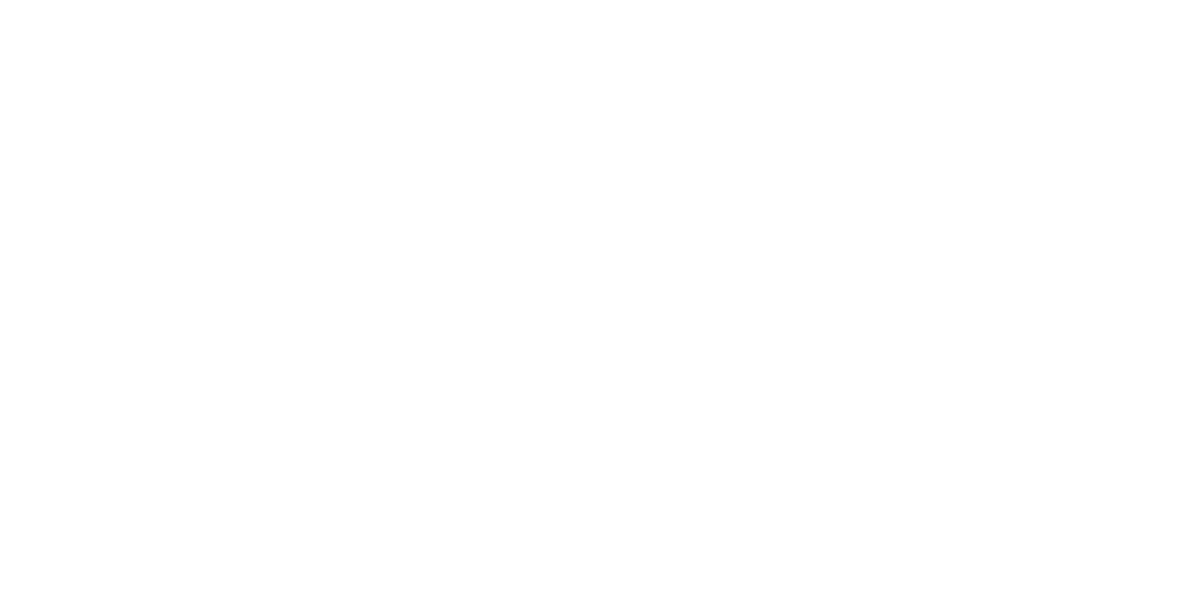

It.: 1 C.: [NaN;;] Vf.: NaN ch.: NaN, p.: 3.0 beta.:2 eta.: 0.5 
  0.000303 seconds (43 allocations: 3.281 KiB)


([NaN; NaN; … ; NaN; NaN;;], Any[[NaN;;]], Any[NaN], 1)

In [55]:
# @time xPhys, opt_hist, vf_hist, loop = Optimization(setup, mat, load, filter, ini, disfeature)
Optimization(setup, mat, load, filter, ini, disfeature)